## - Import Library

In [1]:
import warnings
warnings.filterwarnings('ignore')

import copy
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
from glob import glob

import torch
from torch import nn, optim
from torchvision import transforms, models
from torch_snippets import *
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from torchmetrics import ConfusionMatrix, F1Score
from torchsummary import summary 

## - Pytorch version & Device

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 1.12.0
device: cuda


## - Parameters

In [3]:
# Data
data_path = './data/Face Mask Type Classification' # Data path
train_folder_path = os.path.join(data_path, 'train') # Smoking
test_folder_path = os.path.join(data_path, 'test') # Not smoking
print('Train path:', train_folder_path)
print('Test path:', test_folder_path)

resize_width_height = 224

# Train & test
epochs = 30  # Train epochs
batch_size = 64  # Batch size

# Selecting backbone models
# Options: ['regnet_y_16gf']
model_name = 'regnet_y_16gf'
# regnet_y_16gf Options: ['RegNet_Y_16GF_Weights.IMAGENET1K_V1', RegNet_Y_16GF_Weights.IMAGENET1K_V2]
weights_name = 'RegNet_Y_16GF_Weights.IMAGENET1K_V2'
print('Backbone model:', model_name, '+', weights_name)

# Optimizer
learning_rate = 0.0001

Train path: ./data/Face Mask Type Classification/train
Test path: ./data/Face Mask Type Classification/test
Backbone model: regnet_y_16gf + RegNet_Y_16GF_Weights.IMAGENET1K_V2


## - Class

In [4]:
class_list = sorted(os.listdir(train_folder_path))
print('Class list:', class_list)
class_num = len(class_list)
idx_to_class = {i:class_name for i, class_name in enumerate(class_list)}

Class list: ['cloth', 'n95', 'n95v', 'nfm', 'srg']


## - Build Pytorch Dataset & DataLoader

In [5]:
transforming = train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(resize_width_height),              # resize shortest side
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [6]:
# Train  & data
train_data_dataset = datasets.ImageFolder(train_folder_path, transform=transforming)
print('Test size:', len(train_data_dataset))
train_dataloader = DataLoader(train_data_dataset, batch_size=batch_size, shuffle=True)

# Test data
test_data_dataset = datasets.ImageFolder(test_folder_path, transform=transforming)
print('Test size:', len(test_data_dataset))
test_dataloader = DataLoader(test_data_dataset, batch_size=batch_size, shuffle=False)

Test size: 1956
Test size: 330


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


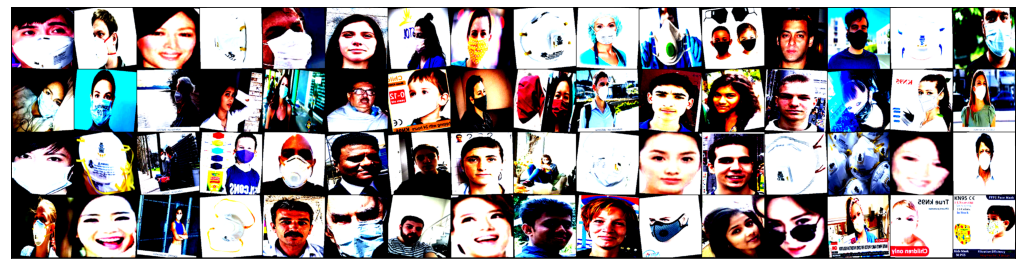

In [7]:
for images, labels in train_dataloader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

In [8]:
inspect(*next(iter(train_dataloader)), names='image, target')

IMAGE:
Tensor	Shape: torch.Size([64, 3, 224, 224])	Min: -2.118	Max: 2.640	Mean: 0.526	dtype: torch.float32 @ cpu
TARGET:
Tensor	Shape: torch.Size([64])	Min: 0.000	Max: 4.000	Mean: 2.172	dtype: torch.int64 @ cpu


## - Face Mask Classification with Pretrained RegNet

In [9]:
class FaceMaskClassifier(nn.Module):
    def __init__(self, class_num, model_name, weights_name, freeze = False, drop_last = True):
        super().__init__()
        
        self.model_name = model_name
        self.weights_name = weights_name
        
        # Load backbone model
        model, last_dim = self.get_backbone_model()
        modules = list(model.children())
        
        # Delete last layer
        if drop_last: 
            modules = modules[:-1] 
        
        self.backbone = nn.Sequential(*modules)
        
        # Freeze backbone
        if freeze:
            for param in self.backbone.parameters():
                param.requires_grad = False
            
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(last_dim),
            nn.Dropout(0.2),
            nn.Linear(last_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, class_num)
        )
    
    def get_backbone_model(self):
        if self.model_name == 'regnet_y_16gf':
            if self.weights_name == 'RegNet_Y_16GF_Weights.IMAGENET1K_V1':
                weights = models.RegNet_Y_16GF_Weights.IMAGENET1K_V1
            elif self.weights_name == 'RegNet_Y_16GF_Weights.IMAGENET1K_V2':
                weights = models.RegNet_Y_16GF_Weights.IMAGENET1K_V2
            
            model = models.regnet_y_16gf(weights=weights)
            last_dim = 3024
        
        return model, last_dim
    
    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

In [10]:
model = FaceMaskClassifier(class_num, model_name, weights_name)
_ = summary(model, torch.zeros(batch_size, 3, resize_width_height, resize_width_height).to(device))

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 3024, 1, 1]          --
|    └─SimpleStemIN: 2-1                      [-1, 32, 112, 112]        --
|    |    └─Conv2d: 3-1                       [-1, 32, 112, 112]        864
|    |    └─BatchNorm2d: 3-2                  [-1, 32, 112, 112]        64
|    |    └─ReLU: 3-3                         [-1, 32, 112, 112]        --
|    └─Sequential: 2-2                        [-1, 3024, 7, 7]          --
|    |    └─AnyStage: 3-4                     [-1, 224, 56, 56]         648,768
|    |    └─AnyStage: 3-5                     [-1, 448, 28, 28]         3,777,032
|    |    └─AnyStage: 3-6                     [-1, 1232, 14, 14]        54,604,200
|    |    └─AnyStage: 3-7                     [-1, 3024, 7, 7]          21,534,212
|    └─AdaptiveAvgPool2d: 2-3                 [-1, 3024, 1, 1]          --
├─Sequential: 1-2                             [-1, 5]             

## - Train & valid Model

In [11]:
def train(data, model, optimizer, loss_fn):
    
    # Set train
    model.train()
    
    # Get batch data
    imgs, targets = data
    imgs = imgs.to(device)
    targets = targets.to(device)
    
    # Inference
    outputs = model(imgs)
    
    # Get loss
    loss = loss_fn(outputs, targets)
    
    # Get class
    preds = outputs.argmax(-1)
    
    acc = (sum(preds==targets) / len(targets))
    
    # Init gradient
    model.zero_grad()
    
    # Backword propagation
    loss.backward()
    
    # Optimization 
    optimizer.step()
    
    return loss, acc

In [12]:
@torch.no_grad()
def validate(data, model, loss_fn, val_output, val_label):
    
    # Set valid
    model.eval()
    
    # Get batch data
    imgs, targets = data
    imgs = imgs.to(device)
    targets = targets.to(device)
    
    # Inference
    outputs = model(imgs)
    
    # Get loss
    loss = loss_fn(outputs, targets)
    
    # Get class
    preds = outputs.argmax(-1)
    
    acc = (sum(preds==targets) / len(targets))
    
    return loss, acc, preds, targets

In [13]:
# Train log
log = Report(epochs)

# Best epochs
best_acc = 0
best_epoch = 1
best_val_output = []

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Gradient sceduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10,
                                     gamma=0.5)

In [14]:
for epoch in range(epochs):
    n_batch = len(train_dataloader)
    for i, data in enumerate(train_dataloader):
        train_loss, train_acc = train(data, model, 
                                      optimizer, loss_fn)
        pos = epoch + ((i+1)/n_batch)
        log.record(pos=pos, train_loss=train_loss, 
                   train_acc=train_acc, end='\r')
    
    val_output = []
    val_label = []
    acc_list = []
    
    n_batch = len(test_dataloader)
    for i, data in enumerate(test_dataloader):
        val_loss, val_acc, preds, targets = validate(data, model, loss_fn, val_output, val_label)
        val_output.extend(list(preds.cpu().numpy()))
        val_label.extend(list(targets.cpu().numpy()))
        acc_list.append(val_acc)
        
        pos = epoch + ((i+1)/n_batch)
        log.record(pos=pos, val_loss=val_loss, val_acc=val_acc, 
                   end='\r')

    if best_acc < float(sum(acc_list) / n_batch):
        best_acc = float(sum(acc_list) / n_batch)
        best_epoch = epoch+1
        best_val_output = val_output
        
    scheduler.step()
    log.report_avgs(epoch+1)

EPOCH: 1.000	train_loss: 0.838	train_acc: 0.698	val_loss: 0.417	val_acc: 0.925	(21.91s - 635.41s remaining)
EPOCH: 2.000	train_loss: 0.231	train_acc: 0.950	val_loss: 0.222	val_acc: 0.953	(44.00s - 616.01s remaining)
EPOCH: 3.000	train_loss: 0.109	train_acc: 0.982	val_loss: 0.143	val_acc: 0.969	(66.13s - 595.14s remaining)
EPOCH: 4.000	train_loss: 0.062	train_acc: 0.997	val_loss: 0.101	val_acc: 0.979	(87.13s - 566.34s remaining)
EPOCH: 5.000	train_loss: 0.038	train_acc: 0.998	val_loss: 0.100	val_acc: 0.966	(108.65s - 543.25s remaining)
EPOCH: 6.000	train_loss: 0.037	train_acc: 0.997	val_loss: 0.111	val_acc: 0.966	(130.65s - 522.62s remaining)
EPOCH: 7.000	train_loss: 0.024	train_acc: 0.998	val_loss: 0.086	val_acc: 0.977	(151.57s - 498.02s remaining)
EPOCH: 8.000	train_loss: 0.027	train_acc: 0.998	val_loss: 0.105	val_acc: 0.969	(172.32s - 473.89s remaining)
EPOCH: 9.000	train_loss: 0.024	train_acc: 0.998	val_loss: 0.085	val_acc: 0.971	(193.32s - 451.07s remaining)
EPOCH: 10.000	train_los

## - Loss & Accuracy Function, Best Accuracy

100%|███████████████████████████████████████| 131/131 [00:00<00:00, 5455.53it/s]


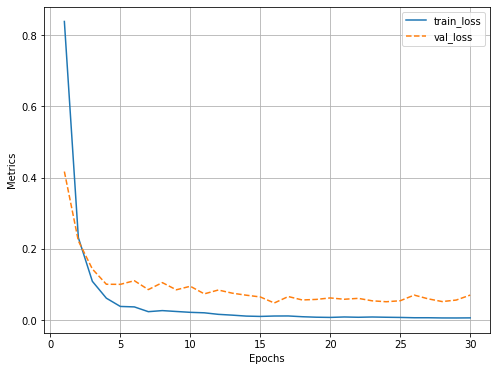

In [15]:
log.plot_epochs(['train_loss', 'val_loss'])

100%|███████████████████████████████████████| 131/131 [00:00<00:00, 5004.95it/s]


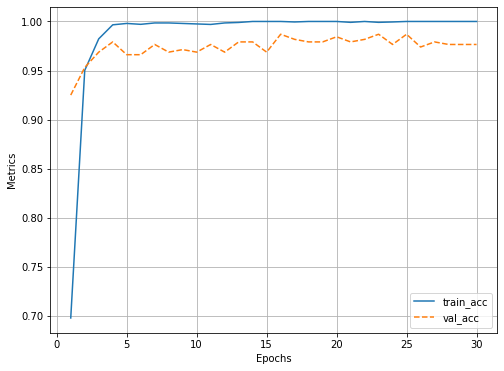

In [16]:
log.plot_epochs(['train_acc', 'val_acc'])

In [17]:
print('Best performance:', float(best_acc), 'Epoch:', best_epoch)

Best performance: 0.9869791865348816 Epoch: 16


## - F1 Score, Confusion Matrix

In [18]:
def plot_confusion_matrix(y_true, y_pred, class_list,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    confmat = ConfusionMatrix(num_classes=len(class_list))
    cm = confmat(torch.tensor(y_pred), torch.tensor(y_true)).cpu().numpy()
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=class_list, yticklabels=class_list,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [19]:
len(best_val_output), len(val_label)

(330, 330)

In [20]:
# F1 score
f1 = F1Score(num_classes=len(class_list))
print('F1 scores:', f1(torch.tensor(val_label), torch.tensor(best_val_output)))

F1 scores: tensor(0.9848)


Confusion matrix, without normalization
[[74  1  0  0  3]
 [ 0 50  0  0  0]
 [ 0  0 48  0  1]
 [ 0  0  0 78  0]
 [ 0  0  0  0 75]]


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

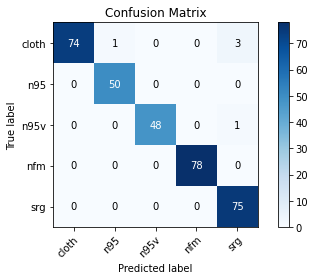

In [21]:
# Confusion Matrix
plot_confusion_matrix(np.array(val_label), np.array(best_val_output), class_list=class_list, normalize=False,
                      title='Confusion Matrix')

## - Test

In [22]:
test_file_path1 = os.path.join(data_path, 'test', 'cloth', '0.jpg')
test_file_path2 = os.path.join(data_path, 'test', 'n95', '354.jpg')
test_file_path3 = os.path.join(data_path, 'test', 'n95v', '0.jpg')
test_file_path4 = os.path.join(data_path, 'test', 'nfm', '0.jpg')
test_file_path5 = os.path.join(data_path, 'test', 'srg', '8.jpg')
print('Test file path1:', test_file_path1)
print('test file path2:', test_file_path2)
print('test file path3:', test_file_path3)
print('test file path4:', test_file_path4)
print('test file path5:', test_file_path5)

Test file path1: ./data/Face Mask Type Classification/test/cloth/0.jpg
test file path2: ./data/Face Mask Type Classification/test/n95/354.jpg
test file path3: ./data/Face Mask Type Classification/test/n95v/0.jpg
test file path4: ./data/Face Mask Type Classification/test/nfm/0.jpg
test file path5: ./data/Face Mask Type Classification/test/srg/8.jpg


In [23]:
test_file_path_list = [test_file_path1, test_file_path2, test_file_path3, test_file_path4, test_file_path5]
test_preds_list = []
show_img_list = []

model.eval()

for test_file_path in test_file_path_list:
    img = Image.open(test_file_path).convert('RGB')
    show_img = copy.deepcopy(img)
    show_img_list.append(show_img)
    
    img = transforming(img)
    img = img.reshape((1,) + img.shape)
    img = torch.tensor(img).to(device)
    
    outputs = model(img)
    test_preds = outputs.argmax(-1)
    test_preds_list.append(test_preds)

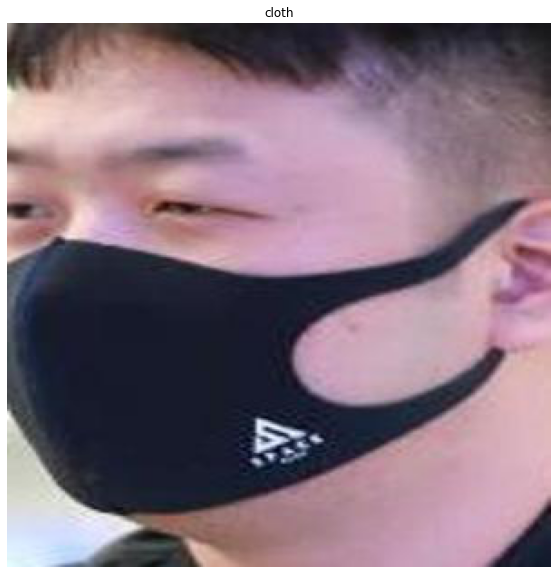

In [24]:
show(show_img_list[0], title=idx_to_class[int(test_preds_list[0])])

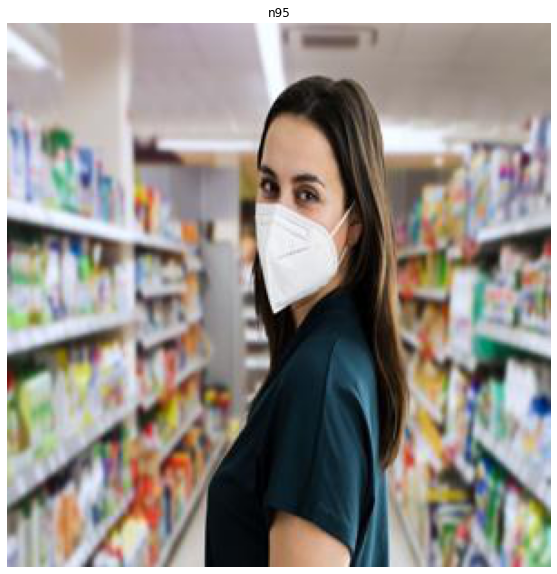

In [25]:
show(show_img_list[1], title=idx_to_class[int(test_preds_list[1])])

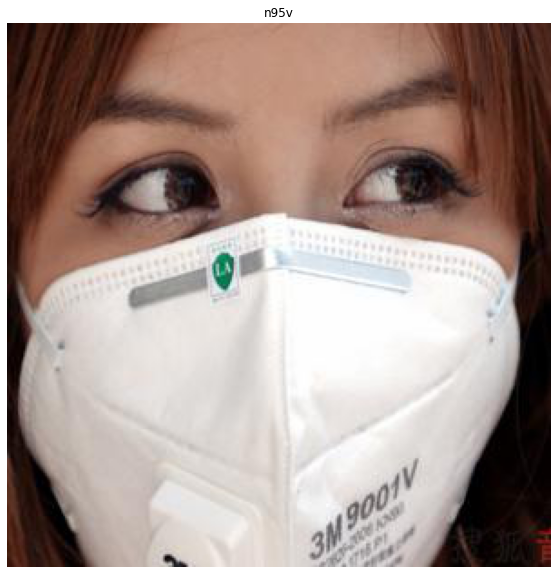

In [26]:
show(show_img_list[2], title=idx_to_class[int(test_preds_list[2])])

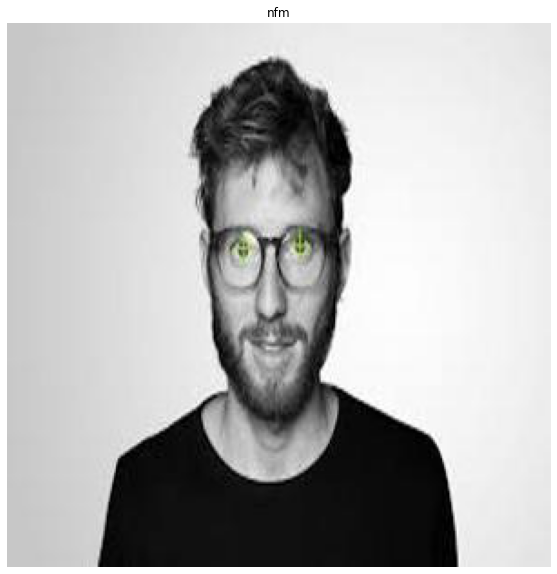

In [27]:
show(show_img_list[3], title=idx_to_class[int(test_preds_list[3])])

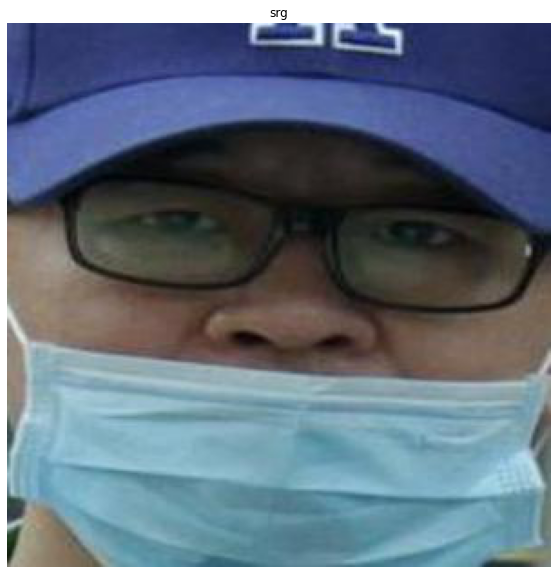

In [28]:
show(show_img_list[4], title=idx_to_class[int(test_preds_list[4])])